In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [30]:
data = fetch_california_housing()
X, y = data.data, data.target

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # shape (n_samples, 1)

# Train/test split 75:25 with random seed 433
torch.manual_seed(433)
dataset = TensorDataset(X, y)
n_train = int(len(dataset) * 0.75)
n_test = len(dataset) - n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 15480, Test samples: 5160


In [31]:
X_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
y_train = torch.stack([train_dataset[i][1] for i in range(len(train_dataset))])
X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
y_test = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.numpy())
X_test_scaled = scaler.transform(X_test.numpy())

# Convert back to tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

# Create new TensorDatasets with scaled data
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([15480, 8]), y_train shape: torch.Size([15480, 1])
X_test shape: torch.Size([5160, 8]), y_test shape: torch.Size([5160, 1])


In [32]:
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32, 16]):
        super(RegressionNN, self).__init__()
        layers = []
        last_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(last_size, h))
            layers.append(nn.ReLU())
            last_size = h
        layers.append(nn.Linear(last_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

input_size = X_train.shape[1]
model = RegressionNN(input_size).to(device)
print(model)

RegressionNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [33]:
batch_size = 32
epochs = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

all_losses = []  # Store loss for EACH batch
batch_counter = 0

model.train()
for epoch in range(epochs):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        
        # Store each batch loss (THIS IS THE KEY FIX!)
        all_losses.append(loss.item())
        batch_counter += 1
    
    # Optional: print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Batches processed: {batch_counter}")

print(f"Training complete! Total batches: {batch_counter}")


Epoch [10/100], Batches processed: 4840
Epoch [20/100], Batches processed: 9680
Epoch [30/100], Batches processed: 14520
Epoch [40/100], Batches processed: 19360
Epoch [50/100], Batches processed: 24200
Epoch [60/100], Batches processed: 29040
Epoch [70/100], Batches processed: 33880
Epoch [80/100], Batches processed: 38720
Epoch [90/100], Batches processed: 43560
Epoch [100/100], Batches processed: 48400
Training complete! Total batches: 48400


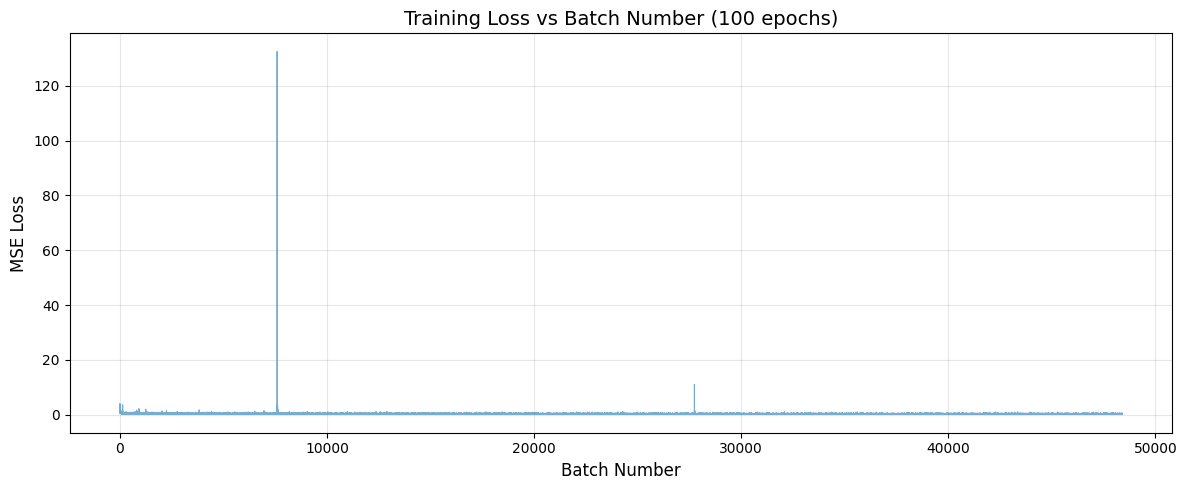

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(all_losses)+1), all_losses, alpha=0.6, linewidth=0.8)
plt.xlabel("Batch Number", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.title("Training Loss vs Batch Number (100 epochs)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_true = y_test.numpy()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print("\nAnalysis:")
print(f"  - Mean Squared Error: {mse:.4f}")
print(f"  - Mean Absolute Error: {mae:.4f}")
print(f"  - Predictions are off by approximately ${mae*100000:.0f} on average")
print(f"  - Model performance: {'Good' if mse < 0.5 else 'Moderate' if mse < 1.0 else 'Needs improvement'}")
print("="*60)

TEST SET EVALUATION
Test MSE: 0.2849
Test MAE: 0.3585

Analysis:
  - Mean Squared Error: 0.2849
  - Mean Absolute Error: 0.3585
  - Predictions are off by approximately $35846 on average
  - Model performance: Good


In [36]:
lrs = [0.1, 0.01, 0.001]
batches = [16, 32, 64]
criterion = nn.MSELoss()
results = {}

print("Starting Grid Search...")
print("="*60)

for lr in lrs:
    for bs in batches:
        print(f"Training with LR={lr}, BS={bs}...")
        
        # Create fresh model for each configuration
        model = RegressionNN(input_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        
        # Train for 100 epochs (or 50 if computational resources are limited)
        all_losses = []
        model.train()
        for epoch in range(100):  # Use 100 for consistency
            batch_losses = []
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())
            all_losses.append(np.mean(batch_losses))
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test.to(device)).cpu().numpy()
            y_true = y_test.numpy()
            mse = mean_squared_error(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)

        results[(lr, bs)] = (mse, mae, all_losses)
        print(f"  → Test MSE={mse:.4f}, MAE={mae:.4f}")

print("="*60)
print("Grid Search Complete!")

Starting Grid Search...
Training with LR=0.1, BS=16...
  → Test MSE=0.6442, MAE=0.6670
Training with LR=0.1, BS=32...
  → Test MSE=1.3572, MAE=0.9329
Training with LR=0.1, BS=64...
  → Test MSE=0.8619, MAE=0.7034
Training with LR=0.01, BS=16...
  → Test MSE=0.3321, MAE=0.3908
Training with LR=0.01, BS=32...
  → Test MSE=0.2614, MAE=0.3446
Training with LR=0.01, BS=64...
  → Test MSE=0.2680, MAE=0.3432
Training with LR=0.001, BS=16...
  → Test MSE=0.2663, MAE=0.3398
Training with LR=0.001, BS=32...
  → Test MSE=0.2614, MAE=0.3442
Training with LR=0.001, BS=64...
  → Test MSE=0.2720, MAE=0.3451
Grid Search Complete!


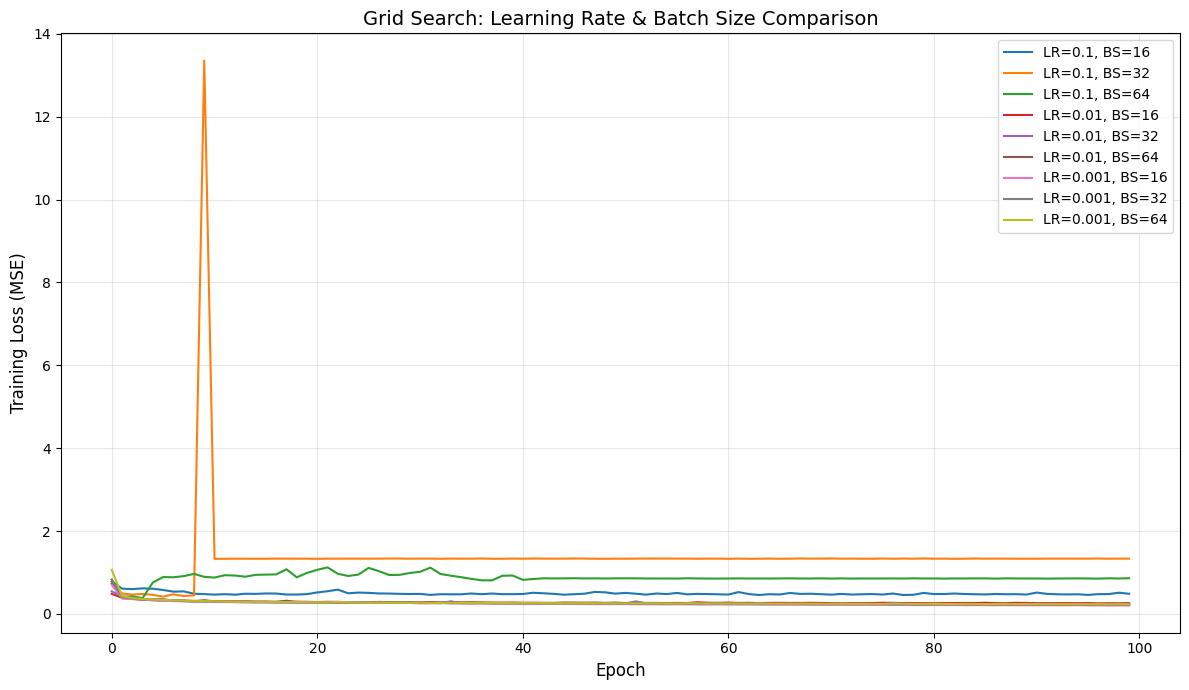

In [37]:
plt.figure(figsize=(12, 7))
for (lr, bs), (mse, mae, losses) in results.items():
    plt.plot(losses, label=f"LR={lr}, BS={bs}", linewidth=1.5)

plt.legend(loc='upper right', fontsize=10)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Training Loss (MSE)", fontsize=12)
plt.title("Grid Search: Learning Rate & Batch Size Comparison", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
print("\n" + "="*70)
print("GRID SEARCH RESULTS SUMMARY")
print("="*70)
print(f"{'Learning Rate':<15} {'Batch Size':<12} {'Test MSE':<12} {'Test MAE':<12}")
print("-"*70)

# Sort results by MSE (best to worst)
sorted_results = sorted(results.items(), key=lambda x: x[1][0])

for (lr, bs), (mse, mae, _) in sorted_results:
    print(f"{lr:<15} {bs:<12} {mse:<12.4f} {mae:<12.4f}")

# Find best configuration
best_config = sorted_results[0]
best_lr, best_bs = best_config[0]
best_mse, best_mae, _ = best_config[1]

print("="*70)
print("🏆 BEST CONFIGURATION:")
print(f"   Learning Rate: {best_lr}")
print(f"   Batch Size: {best_bs}")
print(f"   Test MSE: {best_mse:.4f}")
print(f"   Test MAE: {best_mae:.4f}")
print("="*70)

# Analysis
print("\nAnalysis:")
print(f"  - Best learning rate: {best_lr}")
print(f"  - Best batch size: {best_bs}")
print(f"  - This configuration achieved the lowest test MSE of {best_mse:.4f}")


GRID SEARCH RESULTS SUMMARY
Learning Rate   Batch Size   Test MSE     Test MAE    
----------------------------------------------------------------------
0.001           32           0.2614       0.3442      
0.01            32           0.2614       0.3446      
0.001           16           0.2663       0.3398      
0.01            64           0.2680       0.3432      
0.001           64           0.2720       0.3451      
0.01            16           0.3321       0.3908      
0.1             16           0.6442       0.6670      
0.1             64           0.8619       0.7034      
0.1             32           1.3572       0.9329      
🏆 BEST CONFIGURATION:
   Learning Rate: 0.001
   Batch Size: 32
   Test MSE: 0.2614
   Test MAE: 0.3442

Analysis:
  - Best learning rate: 0.001
  - Best batch size: 32
  - This configuration achieved the lowest test MSE of 0.2614
